## Multilayer perceptron

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense # dense is all neurons connected to all next layer neurons
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [78]:
db = pd.read_csv('db.csv', low_memory=False)
db.shape

(33543, 35)

In [79]:
db.columns

Index(['Unnamed: 0', 'FCS', 'CORR', 'BUFF_OVERFLOW', 'GENERIC', 'PCKT_NUM',
       'TIME(MS)', 'LENGTH', 'PAYLOAD', 'RSSI', 'CRC_OK', 'FRAME_TYPE',
       'SECURITY_ENABLED', 'FRAME_PENDING', 'ACKNOWLEDGE_REQ',
       'PAN_COMPRESSION', 'DEST_PAN', 'DEST_ADD', 'SRC_PAN', 'SRC_ADD', 'DATA',
       'CMD', 'ACK', '1_OCT_HEADER', 'CSL_WAKEUP', 'CSL_SECURE_ACK',
       'RFID_BLINK', 'BCN', 'TEST_TYPE', 'CONTROL', 'DOUBLENETWORK', 'ELECTRO',
       'NORMAL', 'VIENTO', 'WIRELESS'],
      dtype='object')

In [80]:
db = db.drop(['Unnamed: 0'], axis = 1)
db.head()

,FCS,CORR,BUFF_OVERFLOW,GENERIC,PCKT_NUM,TIME(MS),LENGTH,PAYLOAD,RSSI,CRC_OK,...,CSL_SECURE_ACK,RFID_BLINK,BCN,TEST_TYPE,CONTROL,DOUBLENETWORK,ELECTRO,NORMAL,VIENTO,WIRELESS
0,1,1,0,0,1,0.000000,11,NaN,-98.0,1.0,...,0,0,0,control,1,0,0,0,0,0
1,1,1,0,0,2,16751.182375,11,NaN,-99.0,1.0,...,0,0,0,control,1,0,0,0,0,0
2,1,1,0,0,3,1.070000,14,NaN,-90.0,1.0,...,0,0,1,control,1,0,0,0,0,0
3,1,1,0,0,4,652.697750,11,NaN,-91.0,1.0,...,0,0,0,control,1,0,0,0,0,0
4,1,1,0,0,5,2.006625,14,NaN,-90.0,1.0,...,0,0,1,control,1,0,0,0,0,0


In [81]:
ignore = ['PAYLOAD', 'CRC_OK', 'FRAME_TYPE', 'DEST_PAN', 'DEST_ADD', 'SRC_PAN', 'SRC_ADD', 'TEST_TYPE', 'BUFF_OVERFLOW',
          'FCS', 'GENERIC']
y = db['CRC_OK']
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
33538    1.0
33539    0.0
33540    0.0
33541    1.0
33542    1.0
Name: CRC_OK, Length: 33543, dtype: float64

In [82]:
numdb = db.drop(ignore, axis = 1)
d = pd.DataFrame({'OK':y.values})
numdb = pd.concat([numdb, d], axis=1)
numdb.head()

,CORR,PCKT_NUM,TIME(MS),LENGTH,RSSI,SECURITY_ENABLED,FRAME_PENDING,ACKNOWLEDGE_REQ,PAN_COMPRESSION,DATA,...,CSL_SECURE_ACK,RFID_BLINK,BCN,CONTROL,DOUBLENETWORK,ELECTRO,NORMAL,VIENTO,WIRELESS,OK
0,1,1,0.000000,11,-98.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,1.0
1,1,2,16751.182375,11,-99.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,1.0
2,1,3,1.070000,14,-90.0,0.0,0.0,0.0,0.0,0,...,0,0,1,1,0,0,0,0,0,1.0
3,1,4,652.697750,11,-91.0,0.0,0.0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,1.0
4,1,5,2.006625,14,-90.0,0.0,0.0,0.0,0.0,0,...,0,0,1,1,0,0,0,0,0,1.0


In [83]:
mean_rssi = int(numdb['RSSI'].mean())
numdb['RSSI'] = numdb['RSSI'].fillna(mean_rssi)

In [84]:
numdb['SECURITY_ENABLED'] = numdb['SECURITY_ENABLED'].fillna(0)
numdb['FRAME_PENDING'] = numdb['FRAME_PENDING'].fillna(0)
numdb['ACKNOWLEDGE_REQ'] = numdb['ACKNOWLEDGE_REQ'].fillna(0)
numdb['PAN_COMPRESSION'] = numdb['PAN_COMPRESSION'].fillna(0)
numdb['OK'] = numdb['OK'].fillna(0)

In [85]:
numdb[numdb.isna().any(axis=1)]

,CORR,PCKT_NUM,TIME(MS),LENGTH,RSSI,SECURITY_ENABLED,FRAME_PENDING,ACKNOWLEDGE_REQ,PAN_COMPRESSION,DATA,...,CSL_SECURE_ACK,RFID_BLINK,BCN,CONTROL,DOUBLENETWORK,ELECTRO,NORMAL,VIENTO,WIRELESS,OK


In [86]:
xdb = numdb.drop(['OK'], axis = 1)
y = numdb['OK']
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
33538    1.0
33539    0.0
33540    0.0
33541    1.0
33542    1.0
Name: OK, Length: 33543, dtype: float64

In [87]:
X = xdb.to_numpy()
len(X[0]) # n features

23

In [88]:
n_samples, n_features = X.shape
print(n_samples, n_features)

33543 23


In [89]:
X = X.astype(float)

In [90]:
y = y.values
y

array([1., 1., 1., ..., 0., 1., 1.])

In [91]:
len(y)

33543

In [92]:
err = numdb[numdb['OK'] != 1]
err.shape

(658, 24)

In [93]:
import random
num_err = err.shape[0]
indices = list(err.index)
ok = numdb[numdb['OK'] != 0]
num_ok = ok.shape[0]
rows = 0
visited = []
x_bal_ok = np.zeros((err.shape[0], err.shape[1]-1), dtype=float)
while(rows < (num_err-1)):
    r = random.randint(0, numdb.shape[0]-1)
    if r not in visited and r not in indices and r < (len(ok)-1):
        # without ok
        row = ok.values[r, :-1]
        x_bal_ok[rows, :] = row
        visited.append(r)
        rows += 1
x_bal_ok

array([[1.00000000e+00, 2.68500000e+03, 7.67750000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 4.65100000e+03, 7.67625000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.65100000e+03, 3.49300375e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 2.29300000e+03, 1.69250000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.89400000e+03, 7.67750000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [94]:
x_bal_ok.shape

(658, 23)

In [95]:
x_bal = np.zeros((err.shape[0]*2, err.shape[1]-1), dtype=float)
y_bal = np.zeros(err.shape[0]*2, dtype=float)
x_bal[0:err.shape[0],:] = err.values[:,:-1]
y_bal[0:err.shape[0]] = 1.0
x_bal[err.shape[0]:,:] = x_bal_ok
y_bal[err.shape[0]:] = 0.0

In [96]:
def create_model():
    model = Sequential()
    model.add(Dense(n_features, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', metrics=['mse'])
    model.summary()
    return model

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_bal, y_bal, test_size=0.33)

In [99]:
keras_model = create_model()
keras_model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 23)                552       
                                                                 
 dropout_6 (Dropout)         (None, 23)                0         
                                                                 
 dense_10 (Dense)            (None, 4)                 96        
                                                                 
 dropout_7 (Dropout)         (None, 4)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 653
Trainable params: 653
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
177/177 [==============================] - 1

177/177 [==============================] - 0s 1ms/step - loss: 0.4297 - mse: 0.4297
Epoch 75/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4167 - mse: 0.4167
Epoch 76/100
177/177 [==============================] - 0s 1ms/step - loss: 0.3944 - mse: 0.3944
Epoch 77/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4127 - mse: 0.4127
Epoch 78/100
177/177 [==============================] - 0s 1ms/step - loss: 0.3864 - mse: 0.3864
Epoch 79/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4424 - mse: 0.4424
Epoch 80/100
177/177 [==============================] - 0s 1ms/step - loss: 0.3929 - mse: 0.3929
Epoch 81/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4518 - mse: 0.4518
Epoch 82/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4429 - mse: 0.4429
Epoch 83/100
177/177 [==============================] - 0s 1ms/step - loss: 0.4194 - mse: 0.4194
Epoch 84/100
177/177 [=====================

In [100]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

In [101]:
auc_keras

0.6276966196704603

In [102]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.astype(int), y_pred_keras.astype(int), labels=[1,0])
matrix

array([[125, 107],
       [ 62, 141]], dtype=int64)

In [103]:
tpr = matrix[0,0] / (matrix[0,0] + matrix[0,1]*1.0)
fpr = matrix[1,0] / (matrix[1,0] + matrix[1,1]*1.0)
pt = (fpr, tpr)
pt

(0.3054187192118227, 0.5387931034482759)

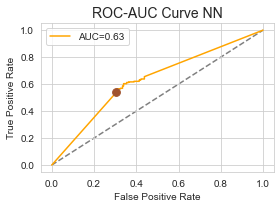

In [104]:
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("flare", as_cmap=True)

plt.figure(figsize=(4, 3))
plt.plot([0, 1], [0, 1], 'k--', color='gray', zorder = -10)
plt.scatter([fpr], [tpr], marker='o', color='sienna', zorder = 10, s = 60)
plt.plot(fpr_keras, tpr_keras, color='orange', label = f"AUC={auc_keras:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve NN', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("roc-curve-nn.png", dpi=500)
plt.show()